# Final Report
## Classification Analysis
### Brandyn Waterman, 3/14/2022, Innis Cohort

Good afternoon! We begin with imports that are needed for operating this notebook:

In [1]:
# Calculations and df manipulation
import pandas as pd
import numpy as np

# Visulaizations
import seaborn as sns
import matplotlib.pyplot as plt

# Math & Statistics
from scipy import stats
import statistics
import math

# SQL access
from env import host, user, password

# Imported modules acquire.py and prepare.py
from acquire import get_telco_data
from prepare import prep_telco
from explore import pie_churn, churn_corr, phone_int, fiber_churn
from explore import senior_churn, monthly_cost, tenure_churn, payment_churn, contract_churn

# sklearn suite for modeling and analysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz, export_text
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Overview:
The purpose of this project is to help reduce churn of customers at Telco. This report will go over the steps that were needed to obtain our **goals** of:
- Identifying key drivers (acquire, prepare, explore)
- Creating classification models for churn prediction (model)
- Providing recommendations and solutions based on the information learned (summary)


### Planning:
The first step in this journey is to establish an initial plan and question set to guide our interactions with the data. 

Some of the initial questions relating to the data are:
1. What is our current baseline of churn?
2. How does plan type (service) impact churn?
3. How does internet type impact churn?
4. Do any demographic attributes impact churn?
5. Does cost impact churn?
6. Does tenure impact churn?

For business purposes:
- How much is this churn costing Telco?


### Acquire:
Under the hood our acquire module is making use of get_db_url() to access the SQL server with our credentials, and then get_telco_data() to query the SQL database for our data. 

Our query selects from customers, internet_service_types, contract_types, and payment_types tables from the 'telco-churn' database. It then converts the SQL response to a dataframe, and that dataframe into a local .csv file. (If the file already exists locally the function checks for this prior to the SQL query) The dataframe is then returned. 


In [2]:
# Calling our function get_telco_data() from the acquire.py module
telco_data = get_telco_data()

Using cached csv


### Prepare:
Under the hood our prepare module uses telco_split() to take in a dataframe and return three dataframes: train, validate, and test. These are a 56%, 24%, and 20% split of the prepared dataframe, respectfully. 

The prep_telco() function takes in our acquired dataframe and cleans it for use. 

The order of steps are as follows:

To ensure we have no duplicates in our data: df = df.drop_duplicates(inplace=True)

To remove some redundant columns (internet_service_type_id, contract_type_id, payment_type_id): df = df.drop(columns=['internet_service_type_id', contract_type_id', 'payment_type_id']) 

To fix the total_charges columns: df.total_charges = df.total_charges.replace(' ', np.nan).astype(float)
- The issue we had was total_charges being the wrong datatype and having empty strings instead of NaN assignments

To address these **missing values**: df.dropna(inplace=True)
- In total there were 11 rows of missing total_charges values. These were due to the tenure of these customers being 0. Since this is a very small portion of the total dataset they were dropped. They did not have enough tenure to be considered relevant and they were causing missing values in the data. 

The data was then separated for categorical columns for encoding by checking if the dtype is 'O' (object): cat_cols = [col for col in df.columns if df[col].dtype == '0']
- We want to ensure that our customer_id column does not get encoded so we remove it before the next step: cat_cols.remove('customer_id')

To iterate through our categorical columns and encode them: 
```for col in cat_cols:
    dummy_df = pd.get_dummies(df[col],
    prefix = df[col].name,
    drop_first = True,
    dummy_na = False)
    df = pd.concat([df, dummy_df], axis=1)
    df = df.drop(columns=col)
    ```
- This will create dummy columns, concat them to our dataframe, and drop the now redundant column.

After our data is encoded the telco_split() function is utilized and our train, validate, and test dataframes are returned. 

In [3]:
# Calling our prep_telco() function, which utilizes the telco_split() function, from our prepare.py module
train, validate, test = prep_telco(telco_data)

### Explore:
We now want to try and delve out as many of the questions we asked initially, and expand on any insights that present themselves from the data.

For the purpose of our statistical analysis we will be using an alpha that is set to .05

In [4]:
alpha = .05

##### Question 1: What is our baseline for churn?
To explore this we will use a pie chart for a simple, 'Churn' or 'No Churn' visual.

We will use the pie_churn() function, with the input of our train dataframe, to display a pie chart.

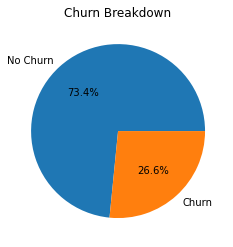

In [5]:
# From the explore module pie_churn() displays our baseline churn status
pie_churn(train)

Before advancing to our other initial questions, we want to get a general sense of correlation to our target of churn. To do this we will use a heatmap with our function churn_corr(). 

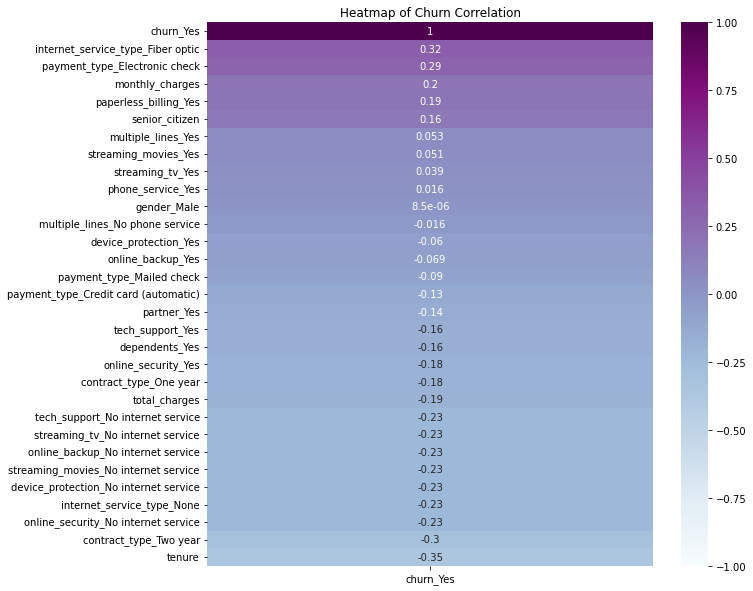

In [6]:
# Calling churn_corr() from our explore module to display a heatmap in relation to our target variable (churn)
churn_corr(train)

From our heatmap we can confirm the need to further investigate tenure and internet type. We can also note the need to explore contract type and payment method. 
- Possible key drivers of churn: Fiber internet and Electronic check payment
- Possible key drivers of retention: (>) Tenure duration, and Two year contracts

##### Question 2: How does plan (service type) impact churn?
From our exploration we concluded that the service type **_(phone only, internet only, or phone and internet)_** with the most impact on churn is **_phone and internet_**.

We will use phone_int() function from explore module to visualize and statistically confirm this.

- Having a Phone and Internet plan and churn are two categorical variables, so we will use a chi^2 test.

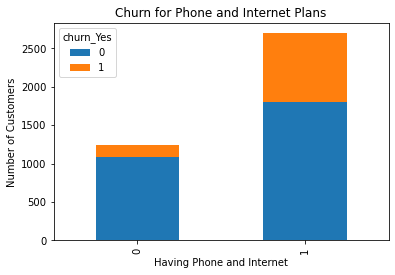

H0: Having a Phone and Internet plan and churn are independent of one another.
HA: Having a Phone and Internet plan and churn are not independent of one another.

chi^2 =  182.5815
p = 1.324e-41

Since our p-value is less than alpha we can reject the null hypothesis.


In [7]:
# Using our train df and alpha to analyze Phone and Internet plans
phone_int(train, alpha)

Our rejection of the null hypothesis confirms that having a phone and internet plan is a key driver of churn.

##### Question 3: How does internet type impact churn?
Our previous conclusion now leads into the next question that we already had in mind, does internet type impact churn? Our exploration concluded that it does, and confirmed our heatmap correlation that Fiber is a key driver of churn. In our workbook we investigated both DSL and Fiber's impact and concluded that the more important driver, by quite a margin, is having Fiber.

We will visually confirm this using fiber_churn() from our explore module. 

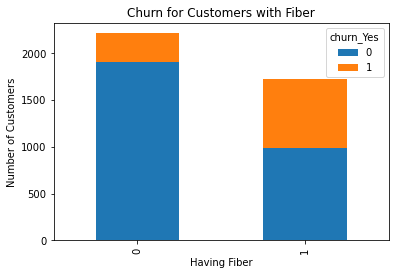

In [8]:
# Using our train df to provide a visual of Fiber internet type and churn
fiber_churn(train)

##### Question 4: Do any demographic (senior_citizen, gender_Male, partner_Yes, dependents_Yes) variables impact churn?
Our exploration weeded out the demographic factors of gender, partners, and dependents and retained senior_citizen as an important variable. 

A visual and statistical confirmation of this can be seen with our senior_churn() function from our explore module.

- senior_citizen and churn are two categorical variables, so we will be using a chi^2 test for this as well.

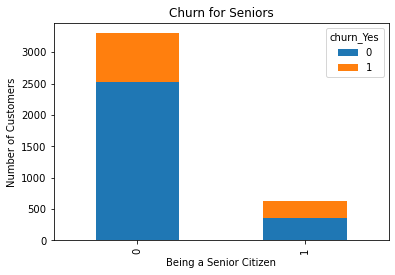

H0: Being a senior citizen and churn are independent of one another.
HA: Being a senior citizen and churn are not independent of one another.

chi^2 =  99.7192
p = 1.756e-23

Since our p-value is less than alpha we can reject the null hypothesis.


In [9]:
# Using our train df and alpha to analyze the impact of being a senior citizen on churn
senior_churn(train, alpha)

Our rejection of the null hypothesis confirms that being a senior citizen is a driver of churn. Even though the 
size of this group is not as large as other drivers it is worth keeping in our features because the rate of churn for this group is so high. 

##### Question 5: Does cost impact churn?
We explored cost by using the monthly_charges variable both visually and with a 1-Tailed Independent T-Test (Two Sample T-Test). Our workbook details that the two samples (_Churn_ and _Not Churned_) are Independent, Normally Distributed with at least 30 observations, and do **not** have equal variances. This is accounted for by equal_var=False when doing the statistical test.

Using monthly_cost() function from explore module we can confirm that monthly_charges is a driver of churn and belongs in our selected features. 

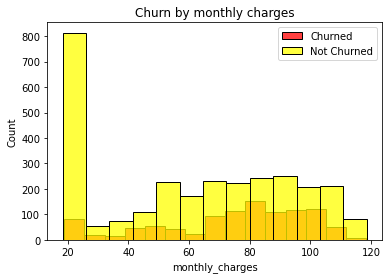

H0: The average monthly charges for customers that churn <= the monthly charges for customers that do not churn.
HA: The average monthly charges for customers that churn > the monthly charges for customers that do not churn.

t =  14.0896
p/2 = 1.23e-43


We can reject our null hypothesis.


In [10]:
# Using our train df and alpha obtaining a visual and statistical confirmation of monthly_charges significance
monthly_cost(train, alpha)

Because our t-value is positive (for test of >) and our p-value is less than alpha.

##### Question 6: Does tenure impact churn?
Similar to the exploration of monthly_charges we explored tenure using visuals and a 1-Tailed Independent T-Test. Our workbook details that the two samples (_Churn_ and _Not Churned_) are independent, Normally distributed with at least 30 observations, and do **not** have equal variances. This is accounted for by equal_var=False when doing the statistical testing. The difference in this statistical test is that we asserting our asserting a < tail instead of a > one. 

Using tenure_churn() function from explore module we can confirm that tenure is a driver of churn and belongs in our selected features.

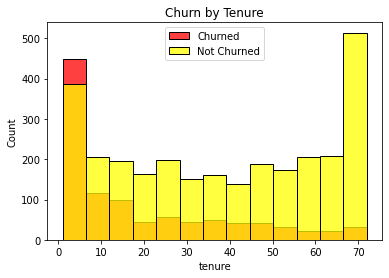

H0: The average tenure for customers that churn >= the tenure for customers that do not churn.
HA: The average tenure for customers that churn < the tenure for customers that do not churn.

t = -25.7700
p/2 = 1.176e-128


We can reject our null hypothesis.


In [11]:
# Using our train df and alpha obtaining a visual and statistical confirmation of tenure significance
tenure_churn(train, alpha)

Because our t-value is negative (for test of <) and our p-value is less than alpha.

### Additional Exploration: Payment types and contract types. 

##### A visual inspection of payment types confirms the significance of Electronic check payment. 

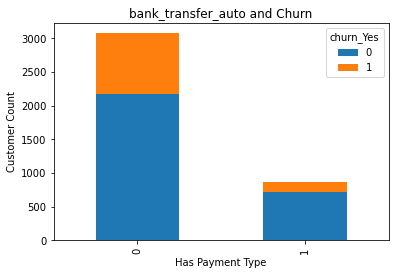

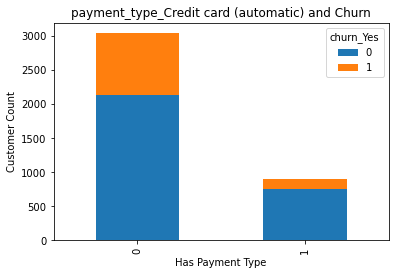

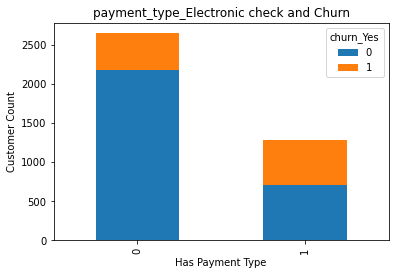

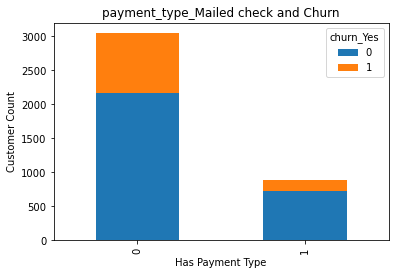

In [12]:
# Using train df to display visual confirmation of Electronic check payment significance
payment_churn(train)

##### A visual inspection of contract types confirms the significance of having No Contract. 

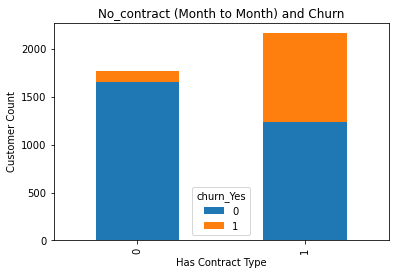

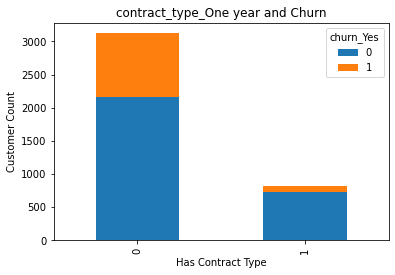

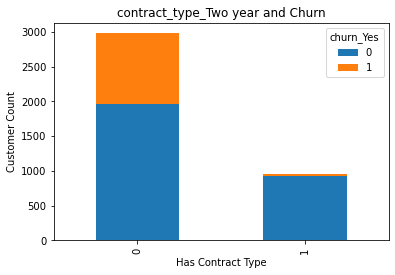

In [13]:
# Using train df to display visual confirmation of No Contract significance
contract_churn(train)

## Exploration Summary:
### Key features driving churn: 
- Phone and Internet plans, that have Fiber
- Customers with a low tenure duration
- Customers with a higher monthly charge
- Customers who pay by Electronic Check
- Customers that do not have a contract
- Customers that are senior citizens (worth keeping in features)

Moving forward with modeling the features that will be utilized will be the above, or those that are needed to infer the above.  

Notable exclusions from the data will be: 
- The suite of 'add on' charges, these did not indicate a strong correlation and are reflected in the monthly charges and other services
- Total Charges, seems somewhat redundant with the inclusion of monthly charges and tenure
- Demographic attributes (gender, partner, dependent)